In [1]:
import numpy as np
import matplotlib.pyplot as plt
from velocity_functions import *
from scipy.integrate import odeint
%matplotlib inline

# Velocity and Integration schemes
The current scheme integrates a 1D scalar conservation law using zero flux B.C. at both walls.
To Do:
1. Come up with a multicomponent flux function using the Lerche 2001 model.
2. plot $(u_{plasma}-u_{bac})$ vs. $\alpha_{RBC}$ to find where backflow occurs.
3. Write upwinding function for two independent waves over x
  1. Start decoupled. Then couple
  2. Include backflow and conditional statements for upwinding.

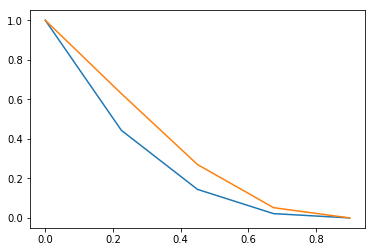

(2, 5)

In [2]:
# Write multicomponent velocity function
def lerche(ρ,ndefs,ρmaxs):
    '''
    Custom velocity function that computes the sedimentation velocity of j
    particle types using the Lerche 2001 form
    Inputs:
        ρ:     ixj array of cell concentrations
        ndefs: tuple of deformation parameters of length j
    Outputs:
        c: ixj array of cell velocities
    '''
    n_cells = len(ndefs)
    nx      = np.shape(ρ)[1]
    
    ρ_tot = np.sum(ρ,axis=0)
    c_out = np.empty((n_cells,nx))
    
    for j in range(n_cells):
        c_out[j,:] = np.nan_to_num((1-(ρ[j,:]/ρ_tot)/ρmaxs[j])**ndefs[j])
    return c_out

RBC = np.linspace(0,0.9,5)
bac = np.linspace(0,0.1,5)
ρcells = np.vstack((RBC,bac))

# plt.plot(RBC,lerche(ρcells,ndefs=(2,2),ρmaxs=(1,1)).T)
# plt.show()
# c_sys(cells,ndefs=(2,1),ρmaxs=(1,1))

speeds = porosity(ρcells)
plt.plot(RBC.T,speeds.T)
plt.show()
np.shape(speeds)

In [3]:
def get_c(ρ,c_rel,mode=None,**kwargs):
    '''
    Return non-dimensional velocity
    Inputs:
        ρ:     jxi array of cell concentrations
        c_rel: jx1 array of stokes velocities of j species normalized to RBCs
        mode:  (optional) hindered settling correction to use: type: string
    Outputs:
        c:     jxi array of velocity of j species corrected for concentration and
               normalized by the max stokes velocity of a RBC (i.e. the outer wall)
               
    TODO: check c_rel dimensions to prevent errors in multiplication in the godunov function.
    '''
    try:
        if mode == 'porosity':
            hsc = porosity(ρ,**kwargs)
        elif mode == 'RZ-1comp':
            hsc = (1-ρ)**2
        elif mode == 'RZ-ncomp':
            hsc = (1-ρ.sum(axis=0))
        # add extra modes for Lerche flux
        
    except:
        # if no hindered settling correction chosen, return c_rel at each spatial point
        hsc = np.ones_like(ρ)
    
    c = c_rel*hsc
    return c

def get_q(ρ_cells,**kwargs):
    '''
    returns the speed and volumetric flux of j particle types
    inputs: jxi array (checkdims for consistency) of j particle concentrations.
    
    stokes velocity ratios should pass to get_c via **kwargs
    output: 
    '''
    # assign slip velocity of cells relative to fluid using HSC
    c_cells_slip = get_c(ρ_cells,**kwargs)
    
    # calculate plasma ρ, initialize array of plasma speeds (0), and combine with cell values
    ρ_plasma = 1-np.sum(ρ_cells,axis=0)
    c_plasma = np.zeros(np.shape(ρ_cells[1]))
    ρ,c_slip = [np.vstack((species,fluid)) for species,fluid in zip((ρ_cells,c_cells_slip),(ρ_plasma,c_plasma))]
    
    # compute absolute velocities (and flux) using Davis and Gecol 1994 equation 2
    c_avg_slip = np.sum(c_slip*ρ,axis=0)
    c_abs = c_slip - c_avg_slip
    q_abs = ρ*c_abs
    
    return q_abs,c_abs

q_abs,c_abs = get_q(ρcells,c_rel=U0_rel,mode='porosity')
plt.plot(RBC.T,q_abs.T)
plt.show()
plt.plot(RBC.T,c_abs.T)
plt.show()
c_abs

NameError: name 'U0_rel' is not defined

### Use godunov function for systems
1. Make it accept a row of values and a row of fluxes
2. Make a wrapper to compute the things...

In [4]:
def godunov_flatten(ρ_bc,t,r,mode,**kwargs):
    '''work in progress. I can keep godunov infrastructure for 1d and feed in row by row.
    Else, I can flatten an ndarray, integrate the whole thing for all time,
    and cast it back into n rows.'''
#     ρ_bc         = np.empty((ρ.shape[0],ngrd+2))
#     ρ_bc[:,0]    = 0.0
#     ρ_bc[:,-1]   = 1.0
#     ρ_bc[:,1:-1] = ρ

#     r_bc       = np.empty(ngrd+2)
#     r_bc[0]    = r[0] -Δx # be careful taking global variables!
#     r_bc[-1]   = r[-1]+Δx
#     r_bc[1:-1] = r
    
#     evaluate fluxes at each cell and initialize cell interfaces
    q = ρ_bc.reshape(2,-1)*get_c(ρ_bc.reshape(2,-1),U0_rel,mode=mode,**kwargs) # I may need r_bc to be dimensional or not.
    qf = np.zeros(ngrdf)
    
    print(ρ_bc,q,qf)
    
    # apply Godunov flux at each cell interface
    for j in range(ngrdf):
        if ρ_bc[j] >= ρ_bc[j+1]:
            qf[j] = max(q[j],q[j+1])
        elif ρ_bc[j] <= 0 and 0 <= ρ_bc[j+1]:
            qf[j] = 0
        else:
            qf[j] = min(q[j],q[j+1])
    
    # apply upwinding scheme with the godunov interface fluxes
    dρdt = 1/Δx*(qf[:-1]-qf[1:])
    return dρdt

def bc(inside,left_edge,right_edge):
    '''Takes ndarray, adds BCs'''
    return np.hstack((left_edge,inside,right_edge))

It will be better to just feed rows in 1 at a time to the Godunov function to decide the fluxes

In [6]:
def godunov_sorter(ρ_bc,q_bc):
    '''Decides interface fluxes based on a 1D 0th order godunov approximation
    Inputs: ρ_bc: 1xj array of cell concentrations (with BC values on the ends)
            q_bc'''
    qf = np.empty(len(ρ_bc)-1)
    
    for j in range(len(ρ_bc)-1):
        if ρ_bc[j] >= ρ_bc[j+1]:
            qf[j] = max(q_bc[j],q_bc[j+1])
        elif ρ_bc[j] <= 0 and 0 <= ρ_bc[j+1]:
            qf[j] = 0
        else:
            qf[j] = min(q_bc[j],q_bc[j+1])
    return qf


In [5]:
# Experimental parameters
ρ_rbc_0 = 0.4
RPM = 3000
rcells = (6.25e-6,2.5e-6)
ρcells = (1090,1050)

tend   = 1      # s
ntimes = 50   
ngrd   = 50
r1     = 0.057  # m
r2     = 0.06   # m
rs     = np.linspace(r1,r2,4)
L      = r2-r1  # m

#### Non-dimensionalize variables
U0 = stokes(RPM,r2,rcells,ρcells) # stokes velocity of each cell type at the max radius (assumes stokes is not f(r))
U0_rel = (U0/U0[0])[:,np.newaxis] # normalize species stokes by RBC at the max radius. Shape=(2,1) for get_c function

T  = L/U0[0]     # seconds it takes to traverse length going at max speed.
cycles = tend/T  # 

# Time and space grids                  Dimensions
times  = np.linspace(0,cycles,ntimes) # 
Δt     = tend/ntimes                  # s
ngrdf  = ngrd+1                       #
xf     = np.linspace(r1/r2,1,ngrdf)   # 
Δx     = xf[1]-xf[0]                  # 
x      = (xf[1:] + xf[:-1])/2         #

ρ0  = np.ones(ngrd)*ρ_rbc_0

RBC = np.linspace(0,0.9,ngrd)
bac = np.linspace(0,0.1,ngrd)
ρcells = np.vstack((RBC,bac))

# add BCs to ρcells and flatten
ρcellsbc = bc(ρcells,np.zeros((2,1)),np.ones((2,1)))
ρall,diag = odeint(godunov_flatten, ρcellsbc.flatten(), times,args=(x,'RZ-1comp'))

[0.         0.         0.01836735 0.03673469 0.05510204 0.07346939
 0.09183673 0.11020408 0.12857143 0.14693878 0.16530612 0.18367347
 0.20204082 0.22040816 0.23877551 0.25714286 0.2755102  0.29387755
 0.3122449  0.33061224 0.34897959 0.36734694 0.38571429 0.40408163
 0.42244898 0.44081633 0.45918367 0.47755102 0.49591837 0.51428571
 0.53265306 0.55102041 0.56938776 0.5877551  0.60612245 0.6244898
 0.64285714 0.66122449 0.67959184 0.69795918 0.71632653 0.73469388
 0.75306122 0.77142857 0.78979592 0.80816327 0.82653061 0.84489796
 0.86326531 0.88163265 0.9        1.         0.         0.
 0.00204082 0.00408163 0.00612245 0.00816327 0.01020408 0.0122449
 0.01428571 0.01632653 0.01836735 0.02040816 0.02244898 0.0244898
 0.02653061 0.02857143 0.03061224 0.03265306 0.03469388 0.03673469
 0.03877551 0.04081633 0.04285714 0.04489796 0.04693878 0.04897959
 0.05102041 0.05306122 0.05510204 0.05714286 0.05918367 0.06122449
 0.06326531 0.06530612 0.06734694 0.06938776 0.07142857 0.07346939
 0.075

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [107]:
# import timeit
# timeit.timeit('np.linalg.eig(np.array([[1,2],[3,4]]))',setup='import numpy as np')
# 100 ms to find eigenvals and vectors of 2x2 array. That's intensive.

test1d = np.arange(6).reshape(2,-1)
bcleft = np.array([[0],[0]])
np.hstack((bcleft,test1d,bcleft)).flatten()

array([0, 0, 1, 2, 0, 0, 3, 4, 5, 0])

In [ ]:
# %matplotlib inline
fig = plt.figure()
fig.figsize=(10,10)

color = plt.get_cmap('Reds')
colors = iter(color(np.linspace(0,1,ntimes)))
for j in range(ntimes):
    plt.plot(x,ρall[j,:],color=next(colors))

plt.xlabel('position')
plt.ylabel(r'$\alpha$')
plt.xlim([r1/r2,1]);
plt.show()

### Animations

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML, Image
rc('animation',html='html5')
%matplotlib inline

fig, ax = plt.subplots()
ax.set_xlim([r1/r2,1])
ax.set_ylim([0,1])
line, = ax.plot([],[])

def init():
    line.set_data([],[])
    ax.set_xlabel('Normalized Distance')
    ax.set_ylabel('Hematocrit')
    return (line,)
def animate(i):
    line.set_data(x,ρall[i,:])
    line.set_color('red')
    return (line,)
anim = animation.FuncAnimation(fig,animate,init_func=init,
                               frames=ntimes,interval=Δt*1000,blit=True)

anim
# anim.save('wave_simulation.mp4')

### Completed steps:
1. non-dimensionalize code for time, flux, and velocity. I will follow Lerche 2001's non-dimensionalization
$$x^{*} = \frac{x}{L}$$
$$T = \frac{L}{U_{0}}$$
$$t^{*} = \frac{tU_{0}}{L} = \frac{t}{T}$$
$$u^{*} = \frac{u}{u_{0}}$$  

### Test godunov for multicomp integration

In [22]:
def godunov(ρ,t,r,cell_params):
    ρ_bc       = np.empty(ngrd+2)
    ρ_bc[0]    = 0.0
    ρ_bc[-1]   = 1.0
    ρ_bc[1:-1] = ρ

    r_bc       = np.empty(ngrd+2)
    r_bc[0]    = r[0] -Δx # be careful taking global variables!
    r_bc[-1]   = r[-1]+Δx
    r_bc[1:-1] = r
    
#     evaluate fluxes at each cell and initialize cell interfaces
    q = ρ_bc*get_c(ρ_bc,r_bc) # I may need r_bc to be dimensional or not.
#     q = get_q(ρ_bc) It won't be that simple to go from scalar integration to system integration.
    qf = np.zeros(ngrdf)
    
    # apply Godunov flux at each cell interface
    for i in range(ngrdf):
        if ρ_bc[i] >= ρ_bc[i+1]:
            qf[i] = max(q[i],q[i+1])
        elif ρ_bc[i] <= 0 and 0 <= ρ_bc[i+1]:
            qf[i] = 0
        else:
            qf[i] = min(q[i],q[i+1])
    
    # apply upwinding scheme with the godunov interface fluxes
    dρdt = 1/Δx*(qf[:-1]-qf[1:])
    return dρdt